In [26]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import pandas as pd
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [27]:
#상위 몇 %를 잘라서 이상치로 보았을 때, 그 안의 precision이 가장 높은 구간
def find_best_percent(result, granularity_all=1000):
    """
    find threshold
    :param result: sorted result
    :param granularity_all: granularity_all
    """
    max_percent = 0
    best_n = 1
    print("threshold tuning start:")
    for n in tqdm(range(1, 100)):
        head_n = n / granularity_all
        data_length = max(round(len(result) * head_n), 1)
        count_dist = count_entries(result.loc[:data_length - 1], 'label')
        try:
            percent = count_dist['1'] / max(1,(count_dist['0'] + count_dist['1']))
            # anormal 갯수 파악.
        except KeyError:
            print("can't find n%,take 1%")
            percent = 0.01
        if percent > max_percent:
            max_percent = percent
            best_n = n
    print("top %d / %s is the highest, %s" % (granularity_all, best_n, max_percent))
    print("Count dist : " ,count_dist)
    return best_n, max_percent, granularity_all

def count_entries(df, col_name):
    """
    count
    """
    count_dist = {'0': 0, '1': 0}
    col = df[col_name]
    for entry in col:
        if str(int(entry)) in count_dist.keys():
            count_dist[str(int(entry))] = count_dist[str(int(entry))] + 1
        else:
            count_dist[str(int(entry))] = 1
    return count_dist

def find_best_result(threshold_n, result, dataframe_std,ind_car_num_list,ood_car_num_list):
    """
    find_best_result
    :param threshold_n: threshold
    :param result: sorted result
    :param dataframe_std: label
    """
    best_result, best_h, best_re, best_fa, best_f1, best_precision = None, 0, 0, 0, 0, 0
    best_auroc = 0
    for h in tqdm(range(10, 1000, 5)):
        train_result = charge_to_car(threshold_n, result, head_n=h)
        f1, recall, false_rate, precision, accuracy, auroc = evaluation(dataframe_std, train_result,ind_car_num_list,ood_car_num_list)
        if auroc >= best_auroc:
            best_f1 = f1
            best_h = h
            best_re = recall
            best_precision = precision
            best_result = train_result
            best_auroc = auroc
    return best_result, best_h, best_re, best_precision, best_f1, best_auroc

def charge_to_car(threshold_n, rec_result, head_n=92):
    """
    mapping from charge to car
    :param threshold_n: threshold
    :param rec_result: sorted result
    :param head_n: top %n
    :param gran: granularity
    """
    gran = 1000
    result = []
    for grp in rec_result.groupby('car'):
        temp = grp[1].values[:, -1].astype(float)
        idx = max(round(head_n / gran * len(temp)), 1)
        error = np.mean(temp[:idx])  
        result.append([grp[0], int(error > threshold_n), error, threshold_n])

        """ top_errors = temp[:idx]
        snip_pred = (top_errors > threshold_n).astype(int)

        ratio = snip_pred.mean() # head_n %의 구간 중 이상 스니펫 비율
        # result.append([grp[0], int(ratio > 0), error, threshold_n]) """ 
    return pd.DataFrame(result, columns=['car', 'predict', 'error', 'threshold_n'])

def evaluation(dataframe_std, dataframe,ind_car_num_list,ood_car_num_list):
    """
    calculated statistics
    :param dataframe_std:
    :param dataframe:
    :return:
    """

    # calculate auroc
#     print(dataframe) # error car
    _label = []
    for each_car in dataframe['car']:
        if int(each_car) in ind_car_num_list:
            _label.append(0)
        if int(each_car) in ood_car_num_list:
            _label.append(1)

    fpr, tpr, thresholds = metrics.roc_curve(_label, list(dataframe['error']), pos_label=1)
    auroc = auc(fpr, tpr)


    data = pd.merge(dataframe_std, dataframe, on='car')
    cm = confusion_matrix(data['label'].astype(int), data['predict'].astype(int))
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1] 
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    false_rate = fp / (tn + fp) if tn + fp != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    return f1, recall, false_rate, precision, accuracy, auroc


    

# Load Data


In [28]:
brand = [1,2,3]
num=brand[0]

train_label_obj = np.load(f"./AUROCscore/labels/brand{num}/train_labels.npy",allow_pickle=True).item()
test_label_obj = np.load(f"./AUROCscore/labels/brand{num}/labels.npy",allow_pickle=True).item()
train_scores = np.load(f"./AUROCscore/scores/brand{num}/tranad_brand1/train_scores.npy",allow_pickle=True).item()
test_scores = np.load(f"./AUROCscore/scores/brand{num}/tranad_brand1/test_scores.npy",allow_pickle=True).item()

loaded_obj = {}
for num in brand:
    train_obj = np.load(f"./AUROCscore/labels/brand{num}/train_labels.npy",allow_pickle=True).item()
    test_obj = np.load(f"./AUROCscore/labels/brand{num}/labels.npy",allow_pickle=True).item()
    loaded_obj[num] = list(train_obj.keys())
    loaded_obj[num].extend(list(test_obj.keys()))


In [29]:
train_list = []
for k,v in train_scores.items():
    train_list.append(len(v))
print(train_list)
print(len(train_list))

test_list = []
for k,v in test_scores.items():
    test_list.append(len(v))
print(test_list)
print(len(test_list))
print(test_label_obj)


[2736, 84, 4319, 597, 1065, 2296, 865, 4380, 1166, 1348, 3839, 877, 82, 3343, 3622, 744, 847, 857, 8341, 2905, 731, 4659, 3865, 3551, 135, 708, 330, 611, 4150, 1969, 7139, 6956, 1506, 2093, 71, 3250, 3166, 7211, 6516, 3591, 4044, 3774, 1047, 583, 6940, 3865, 3973, 873, 1909, 7738, 11, 5279, 4570, 5143, 2588, 5456, 646, 971, 6483, 567, 6895, 688, 1128, 363, 4404, 1229, 5870, 4364, 4542, 502, 3997, 6363, 2290, 1026, 51, 4024, 3943, 699, 3834, 2045, 4838, 1506, 781, 3040, 2713, 1077, 6039, 40, 4921, 762, 810, 631, 1505, 931, 854, 5704, 437, 4399, 3385, 1966, 3445, 3767, 659, 3214, 880, 8368, 84, 687, 5249, 3055, 1809, 6153, 3956, 5380, 2610, 4272, 1977, 6167, 1153, 3309, 3329, 1022, 5450, 2456, 5535, 4028, 1020, 740, 727, 4217, 5057, 659, 1042, 4660, 3881]
135
[1415, 312, 758, 245, 197, 3402, 4291, 3398, 6, 708, 1554, 2660, 1015, 1188, 58, 2021, 2063, 573, 52, 261, 841, 28, 3579, 727, 1414, 549, 2419, 97, 278, 56, 6858, 418, 117, 797, 155, 1127, 748, 2074, 534, 1015, 681, 270, 1849, 525, 

In [30]:
""" train_temp = train_scores.copy()
test_temp = test_scores.copy()
for cid, data in train_scores.items():
    if len(data)<100 : 
        del train_temp[cid]
        del train_label_obj[cid]

for cid, data in test_scores.items():
    if len(data) <100 :
        del test_temp[cid]
        del test_label_obj[cid]

print(len(train_temp.keys()))
print(len(test_temp.keys()))

train_scores = train_temp
test_scores = test_temp """

' train_temp = train_scores.copy()\ntest_temp = test_scores.copy()\nfor cid, data in train_scores.items():\n    if len(data)<100 : \n        del train_temp[cid]\n        del train_label_obj[cid]\n\nfor cid, data in test_scores.items():\n    if len(data) <100 :\n        del test_temp[cid]\n        del test_label_obj[cid]\n\nprint(len(train_temp.keys()))\nprint(len(test_temp.keys()))\n\ntrain_scores = train_temp\ntest_scores = test_temp '

In [31]:
train_scores.update(test_scores) # train, test 하나로 합침.
ind_car_num_list = list(train_label_obj.keys())
ood_car_num_list = []
#Total_FN_car = [171,184,105,21,196,119]

for k,v in test_label_obj.items():
    if test_label_obj[k]==1:
        ood_car_num_list.append(k)
    else :
        ind_car_num_list.append(k)

all_car_num_list = set(ind_car_num_list + ood_car_num_list)
print(len(all_car_num_list))

198


In [32]:
rows = []

for car_id, snippet_scores in train_scores.items():
    if car_id in ind_car_num_list:
        label = 0
    elif car_id in ood_car_num_list:
        label = 1
    else :
        continue

    for s in snippet_scores:
        rows.append([car_id,label,float(s)])

all_snippet_df = pd.DataFrame(rows,columns=['car','label','rec_error'])
print(len(ind_car_num_list))
print(len(ood_car_num_list))

168
30


In [33]:
labels = []
for each_car in all_car_num_list:
    if each_car in ind_car_num_list:
        label = 0
    elif each_car in ood_car_num_list:
        label = 1
    labels.append([each_car,int(label)])
dataframe = pd.DataFrame(labels,columns=['car','label'])

Fold Num0 Test car List : {1, 2, 3, 4, 5, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 169, 42, 171, 44, 174, 49, 181, 182, 183, 184, 185, 186, 190, 191, 192, 194, 68, 197, 196, 78, 91, 98, 105, 107, 108, 119}
169,171,174,49,181,182,183,184,185,186,190,191,192,194,68,197,196,78,91,98,105,107,108,119,
Fold Num0 Train car List : {6, 9, 10, 13, 15, 21, 22, 23, 33, 41, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 106, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 172, 173, 175, 176, 177, 178, 179, 180, 1

100%|██████████| 99/99 [00:00<00:00, 160.42it/s]


top 1000 / 1 is the highest, 0.2125984251968504
Count dist :  {'0': 37160, '1': 579}
threshold_n 0.0006429965142160654
start tuning, flag is rec_error


100%|██████████| 198/198 [00:02<00:00, 75.92it/s]


dataframe_std is  198 &&   dataframe is  141
F1 Scores through Train data
best 1000 / 40:
re: 0.5
fa: 0.75
F1: 0.6
{'1': 'TN', '105': 'FN', '107': 'TP', '108': 'FN', '11': 'TN', '119': 'FN', '12': 'TN', '14': 'FP', '16': 'TN', '169': 'TP', '17': 'TN', '171': 'FN', '174': 'FN', '18': 'TN', '181': 'TP', '182': 'TP', '183': 'TP', '184': 'FN', '185': 'TP', '186': 'TP', '19': 'TN', '190': 'TP', '191': 'TP', '192': 'FN', '194': 'TP', '196': 'FN', '197': 'TP', '2': 'TN', '20': 'TN', '24': 'TN', '25': 'TN', '26': 'TN', '27': 'TN', '28': 'TN', '29': 'TN', '3': 'TN', '30': 'TN', '31': 'TN', '32': 'TN', '34': 'TN', '35': 'FP', '36': 'TN', '37': 'TN', '38': 'TN', '39': 'TN', '4': 'TN', '40': 'TN', '42': 'TN', '44': 'FP', '49': 'FN', '5': 'TN', '68': 'FN', '7': 'TN', '78': 'TP', '8': 'TN', '91': 'FN', '98': 'TP'}
57
Sort by brand :  {1: [('105', 'FN'), ('108', 'FN'), ('119', 'FN'), ('14', 'FP'), ('171', 'FN'), ('174', 'FN'), ('184', 'FN'), ('192', 'FN'), ('196', 'FN'), ('35', 'FP'), ('44', 'FP'), (

100%|██████████| 99/99 [00:00<00:00, 172.86it/s]


top 1000 / 1 is the highest, 0.16954022988505746
Count dist :  {'0': 33622, '1': 859}
threshold_n 0.0009859709534794092
start tuning, flag is rec_error


100%|██████████| 198/198 [00:02<00:00, 81.07it/s]


dataframe_std is  198 &&   dataframe is  140
F1 Scores through Train data
best 1000 / 55:
re: 0.3333333333333333
fa: 0.4
F1: 0.3636363636363636
{'105': 'FN', '107': 'TP', '108': 'FN', '119': 'FN', '130': 'FN', '136': 'TP', '140': 'FN', '150': 'FN', '157': 'TP', '183': 'TP', '184': 'FN', '185': 'FN', '186': 'TP', '190': 'TP', '191': 'FN', '192': 'FN', '194': 'TP', '196': 'FN', '197': 'TP', '21': 'FN', '45': 'TN', '46': 'TN', '47': 'TN', '48': 'TN', '50': 'TN', '51': 'TN', '52': 'TN', '53': 'TN', '54': 'TN', '55': 'TN', '56': 'TN', '57': 'TN', '58': 'TN', '59': 'TN', '60': 'TN', '61': 'TN', '62': 'TN', '63': 'TN', '64': 'TN', '65': 'TN', '66': 'TN', '67': 'TN', '68': 'FN', '69': 'TN', '70': 'TN', '71': 'TN', '73': 'TN', '74': 'TN', '75': 'TN', '76': 'TN', '77': 'TN', '78': 'TP', '79': 'TN', '80': 'TN', '81': 'TN', '82': 'TN', '91': 'FN', '98': 'TP'}
58
Sort by brand :  {1: [('105', 'FN'), ('108', 'FN'), ('119', 'FN'), ('130', 'FN'), ('140', 'FN'), ('150', 'FN'), ('184', 'FN'), ('185', 'F

100%|██████████| 99/99 [00:00<00:00, 159.30it/s]


top 1000 / 1 is the highest, 0.8342105263157895
Count dist :  {'0': 35103, '1': 2523}
threshold_n 0.001849290682002902
start tuning, flag is rec_error


100%|██████████| 198/198 [00:02<00:00, 75.35it/s]
/home/junki/miniconda3/envs/tranad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


dataframe_std is  198 &&   dataframe is  141
F1 Scores through Train data
best 1000 / 995:
re: 0.0
fa: 0
F1: 0
{'100': 'TN', '102': 'TN', '103': 'TN', '104': 'TN', '105': 'FN', '106': 'TN', '107': 'FN', '108': 'FN', '109': 'TN', '110': 'TN', '113': 'TN', '114': 'TN', '115': 'TN', '116': 'TN', '117': 'TN', '118': 'TN', '119': 'FN', '122': 'TN', '123': 'TN', '124': 'TN', '125': 'TN', '129': 'TN', '130': 'FN', '131': 'TN', '132': 'TN', '133': 'TN', '136': 'FN', '140': 'FN', '150': 'FN', '157': 'FN', '169': 'FN', '171': 'FN', '174': 'FN', '181': 'FN', '182': 'FN', '192': 'FN', '194': 'FN', '196': 'FN', '197': 'FN', '21': 'FN', '49': 'FN', '68': 'FN', '78': 'FN', '84': 'TN', '85': 'TN', '87': 'TN', '88': 'TN', '90': 'TN', '91': 'FN', '92': 'TN', '93': 'TN', '94': 'TN', '95': 'TN', '96': 'TN', '97': 'TN', '98': 'FN', '99': 'TN'}
57
Sort by brand :  {1: [('105', 'FN'), ('107', 'FN'), ('108', 'FN'), ('119', 'FN'), ('130', 'FN'), ('136', 'FN'), ('140', 'FN'), ('150', 'FN'), ('157', 'FN'), ('169

100%|██████████| 99/99 [00:00<00:00, 171.77it/s]


top 1000 / 1 is the highest, 0.3389355742296919
Count dist :  {'0': 34156, '1': 1220}
threshold_n 0.0011011302703991532
start tuning, flag is rec_error


100%|██████████| 198/198 [00:02<00:00, 81.40it/s]


dataframe_std is  198 &&   dataframe is  140
F1 Scores through Train data
best 1000 / 630:
re: 0.0
fa: 0
F1: 0
{'105': 'FN', '107': 'FN', '108': 'FN', '119': 'FN', '130': 'FN', '134': 'TN', '135': 'TN', '136': 'FN', '139': 'TN', '140': 'FN', '143': 'TN', '145': 'TN', '146': 'TN', '147': 'TN', '148': 'TN', '149': 'TN', '150': 'FN', '152': 'TN', '153': 'TN', '154': 'TN', '155': 'TN', '156': 'TN', '157': 'FN', '158': 'TN', '159': 'TN', '161': 'TN', '163': 'TN', '164': 'TN', '165': 'TN', '167': 'TN', '168': 'TN', '169': 'FN', '170': 'TN', '171': 'FN', '172': 'TN', '173': 'TN', '174': 'FN', '175': 'TN', '176': 'TN', '177': 'TN', '178': 'TN', '180': 'TN', '181': 'FN', '182': 'TP', '183': 'TP', '184': 'FN', '185': 'FN', '186': 'FN', '187': 'TN', '189': 'TN', '190': 'TP', '191': 'FN', '193': 'TN', '195': 'TN', '21': 'FN', '49': 'FN', '91': 'FN', '98': 'FN'}
58
Sort by brand :  {1: [('105', 'FN'), ('107', 'FN'), ('108', 'FN'), ('119', 'FN'), ('130', 'FN'), ('136', 'FN'), ('140', 'FN'), ('150', 

100%|██████████| 99/99 [00:00<00:00, 157.66it/s]


top 1000 / 1 is the highest, 0.2210796915167095
Count dist :  {'0': 37666, '1': 843}
threshold_n 0.0007801204337738454
start tuning, flag is rec_error


100%|██████████| 198/198 [00:02<00:00, 76.76it/s]


dataframe_std is  198 &&   dataframe is  140
F1 Scores through Train data
best 1000 / 745:
re: 0.16666666666666666
fa: 1.0
F1: 0.2857142857142857
{'10': 'TN', '101': 'TN', '111': 'TN', '112': 'TN', '120': 'TN', '121': 'TN', '126': 'TN', '127': 'TN', '128': 'TN', '13': 'TN', '130': 'FN', '136': 'FN', '137': 'TN', '138': 'TN', '140': 'FN', '141': 'TN', '142': 'TN', '144': 'TN', '15': 'TN', '150': 'FN', '151': 'TN', '157': 'FN', '160': 'TN', '162': 'TN', '166': 'TN', '169': 'FN', '171': 'FN', '174': 'FN', '179': 'TN', '181': 'FN', '182': 'TP', '183': 'TP', '184': 'FN', '185': 'FN', '186': 'FN', '188': 'TN', '190': 'TP', '191': 'FN', '192': 'FN', '194': 'TP', '196': 'FN', '197': 'FN', '198': 'TN', '21': 'FN', '22': 'TN', '23': 'TN', '33': 'TN', '41': 'TN', '43': 'TN', '49': 'FN', '6': 'TN', '68': 'FN', '72': 'TN', '78': 'FN', '83': 'TN', '86': 'TN', '89': 'TN', '9': 'TN'}
58
Sort by brand :  {1: [('130', 'FN'), ('136', 'FN'), ('140', 'FN'), ('150', 'FN'), ('157', 'FN'), ('169', 'FN'), ('17

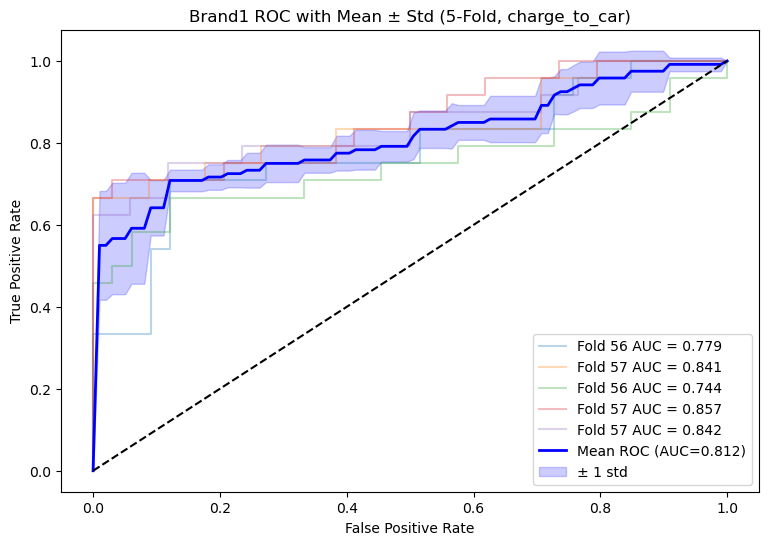

Fold AUCs: [0.7790404040404041, 0.8406862745098039, 0.7436868686868686, 0.8566176470588235, 0.8419117647058824]
AUC mean  0.8123885918003564


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc, precision_recall_fscore_support

mean_fpr = np.linspace(0, 1, 100)
tprs = []
AUC_fivefold_list = []
plt.figure(figsize=(9,6))
for i in range(5):
    
    fold_num = i
    test_car_list = ind_car_num_list[
        int(fold_num * len(ind_car_num_list) / 5) : int((fold_num + 1) * len(ind_car_num_list) / 5)
    ] + ood_car_num_list[: int(fold_num * len(ood_car_num_list) / 5)] \
      + ood_car_num_list[int((fold_num + 1) * len(ood_car_num_list) / 5) :]
    test_car_list = set(test_car_list)
    train_car_list = all_car_num_list - test_car_list

    print(f"Fold Num{fold_num} Test car List : {test_car_list}")
    for cid in test_car_list:
        if cid in ood_car_num_list:
            print(cid,end=",")
    print("",end='\n')
    print(f"Fold Num{fold_num} Train car List : {train_car_list}")

    # 각 fold 별 몇대의 brand차가 분포해 있는지 확인
    brand1, brand2, brand3 = 0,0,0
    for cid in test_car_list:
        if cid in loaded_obj[1]:
            brand1+=1
        elif cid in loaded_obj[2]:
            brand2+=1
        elif cid in loaded_obj[3]:
            brand3 += 1

    print(f"Fold Num {fold_num} Brand1 : {brand1}, Brand2 : {brand2}, Brand3 : {brand3}")

    # ------------------------------
    # Train part: threshold_n, best_h 튜닝
    # ------------------------------
    train_result = all_snippet_df[all_snippet_df['car'].isin(train_car_list)].copy()
    test_result  = all_snippet_df[all_snippet_df['car'].isin(test_car_list)].copy()      
    
    train_res_csv = train_result[['label','car','rec_error']].to_numpy()
    test_res_csv  = test_result[['label','car','rec_error']].to_numpy()

    rec_sorted_index = np.argsort(-train_res_csv[:, 2].astype(float))  # 정렬한 인덱스 반환
    res = [train_res_csv[j][[1, 0, 2]] for j in rec_sorted_index]      # [car, label, rec_error]
    result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
    
    best_n, max_percent, granularity = find_best_percent(result, granularity_all=1000)
    head_n = best_n / granularity
    data_length = max(1,round(len(result) * head_n))
    # threshold_n : precision이 최대가 되는 지점의 임계값.
    if result.empty:
        threshold_n = 1e-7
    else : 
        threshold_n = result['rec_error'].values[data_length - 1].astype(float)
    
    print("threshold_n", threshold_n)
    print("start tuning, flag is", 'rec_error')
    best_result, best_h, best_re, best_fa, best_f1, best_auroc = find_best_result(
        threshold_n, result, dataframe,ind_car_num_list,ood_car_num_list
    )
    if dataframe.shape[0] != best_result.shape[0]:
        print('dataframe_std is ', dataframe.shape[0], '&&   dataframe is ', best_result.shape[0])
        
    print("F1 Scores through Train data")
    print("best 1000 / %d:" % best_h)
    print("re:", best_re)
    print("fa:", best_fa)
    print("F1:", best_f1)
    
    # ------------------------------
    # Test part: charge_to_car → car-level score / 예측
    # ------------------------------
    rec_sorted_index = np.argsort(-test_res_csv[:, 2].astype(float))
    res = [test_res_csv[j][[1, 0, 2]] for j in rec_sorted_index]
    result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])

    result['car'] = result['car'].astype("int").astype("str")

    test_result_car = charge_to_car(threshold_n, result, head_n=best_h)
    # columns: ['car', 'predict', 'error', 'threshold_n']

    _score = list(test_result_car['error'])
    y_true = []
    for each_car in test_result_car['car']:
        if int(each_car) in ind_car_num_list:
            y_true.append(0)
        if int(each_car) in ood_car_num_list:
            y_true.append(1)
    y_pred = list(test_result_car['predict'])  # charge_to_car에서 0/1로 만들어 둔 것

    # pred 와 true가 일치하는 경우 1 아닌 경우 0
    match = {}
    for i,cid in enumerate(test_result_car['car']):
        if (y_true[i] ==0 and y_pred[i]==0):
            match[cid] = "TN"
        elif (y_true[i] == 1 and y_pred[i] == 0):
            match[cid] = "FN"
        elif (y_true[i] == 0 and y_pred[i]==1):
            match[cid] = "FP"
        elif (y_true[i] == 1 and y_pred[i]==1):
            match[cid] = "TP"
    print(match)
    print(len(match.keys()))
    sort_by_brand = {1:[],2:[],3:[]}
    for cid,value in match.items():
        if int(cid) in loaded_obj[1] and value[0]=='F':
            sort_by_brand[1].append((cid,value))
        elif int(cid) in loaded_obj[2] and value[0]=='F':
            sort_by_brand[2].append((cid,value))
        elif int(cid) in loaded_obj[3] and value[0]=='F':
            sort_by_brand[3].append((cid,value))

    print("Sort by brand : ", sort_by_brand)
    print("Brand1 : ",len(sort_by_brand[1]))
    print("Brand2 : ",len(sort_by_brand[2]))
    print("Brand3 : ",len(sort_by_brand[3]))
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, pos_label=1, average='binary'
    )

    print("F1 Score through Test data")
    print("Test Precision:", precision)
    print("Test Recall:", recall)
    print("Test F1:", f1)

    print('len(_score)', len(_score))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, _score, pos_label=1)
    auc_fold = auc(fpr, tpr)
    print('AUC', auc_fold)
    # np.save(f"/results/true_score_fold{i}.npy",y_true)
    # np.save(f"/results/pred_score_fold{i}.npy",_score)
    # fold별 ROC 그리기
    plt.plot(fpr, tpr, alpha=0.3, label=f"Fold {i} AUC = {auc_fold:.3f}")

    # mean ROC 계산용 보간
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    AUC_fivefold_list.append(auc_fold)

# ------------------------------
# 5-fold 평균 ROC + 표준편차 밴드
# ------------------------------
mean_tpr = np.mean(tprs, axis=0)
std_tpr  = np.std(tprs, axis=0)
mean_tpr[-1] = 1.0  # 끝점 보정

plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC={np.mean(AUC_fivefold_list):.3f})"
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="blue",
    alpha=0.2,
    label="± 1 std"
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Brand1 ROC with Mean ± Std (5-Fold, charge_to_car)")
plt.legend()
plt.show()

print("Fold AUCs:", AUC_fivefold_list)
print("AUC mean ", np.mean(AUC_fivefold_list))
